In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import itertools
import warnings
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

In [2]:
# Load dataset
data = pd.read_csv('global_superstore_orders.csv', encoding='ISO-8859-1')

In [3]:
data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31/07/2012,31/07/2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.570,Critical
1,26341,IN-2013-77878,05/02/2013,07/02/2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.630,Critical
2,25330,IN-2013-71249,17/10/2013,18/10/2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.490,Medium
3,13524,ES-2013-1579342,28/01/2013,30/01/2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.160,Medium
4,47221,SG-2013-4320,05/11/2013,06/11/2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.040,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2014-62366,19/06/2014,19/06/2014,Same Day,KE-16420,Katrina Edelman,Corporate,Kure,Hiroshima,...,OFF-FA-10000746,Office Supplies,Fasteners,"Advantus Thumb Tacks, 12 Pack",65.100,5,0.0,4.5000,0.010,Medium
51286,35398,US-2014-102288,20/06/2014,24/06/2014,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,Houston,Texas,...,OFF-AP-10002906,Office Supplies,Appliances,Hoover Replacement Belt for Commercial Guardsm...,0.444,1,0.8,-1.1100,0.010,Medium
51287,40470,US-2013-155768,02/12/2013,02/12/2013,Same Day,LB-16795,Laurel Beltran,Home Office,Oxnard,California,...,OFF-EN-10001219,Office Supplies,Envelopes,"#10- 4 1/8"" x 9 1/2"" Security-Tint Envelopes",22.920,3,0.0,11.2308,0.010,High
51288,9596,MX-2012-140767,18/02/2012,22/02/2012,Standard Class,RB-19795,Ross Baird,Home Office,Valinhos,São Paulo,...,OFF-BI-10000806,Office Supplies,Binders,"Acco Index Tab, Economy",13.440,2,0.0,2.4000,0.003,Medium


In [4]:
drop_columns = [
    'Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
    'Customer Name', 'City', 'State', 'Country', 'Quantity',
    'Postal Code', 'Market', 'Product ID', 
    'Product Name', 'Discount', 'Shipping Cost', 'Order Priority'
]
data = data.drop(columns=drop_columns).dropna().drop_duplicates().sort_values(by='Order Date', ascending=True).reset_index(drop=True)

In [5]:
data

,Order Date,Segment,Region,Category,Sub-Category,Sales,Profit
0,01/01/2011,Consumer,EMEA,Office Supplies,Storage,66.1200,29.6400
1,01/01/2011,Consumer,Africa,Office Supplies,Storage,408.3000,106.1400
2,01/01/2011,Consumer,Oceania,Office Supplies,Supplies,120.3660,36.0360
3,01/01/2011,Consumer,Oceania,Furniture,Furnishings,113.6700,37.7700
4,01/01/2011,Consumer,Oceania,Office Supplies,Paper,55.2420,15.3420
...,...,...,...,...,...,...,...
51272,31/12/2014,Consumer,EMEA,Technology,Accessories,32.5920,-25.2780
51273,31/12/2014,Consumer,North Asia,Office Supplies,Art,39.6000,6.6600
51274,31/12/2014,Home Office,Central,Office Supplies,Paper,120.2400,30.0000
51275,31/12/2014,Corporate,Southeast Asia,Technology,Phones,293.6208,88.4208


In [6]:
df1, df2, df3, df4, df5, df6 = [data.copy() for _ in range(6)]

for df in [df1, df2, df3, df4, df5, df6]:
    df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
    monthly_sales = df.groupby(df['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
    monthly_sales.columns = ['ds', 'y']
    monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

In [7]:
# Random Forest forecast

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Normalized RMSE of Random Forest: 0.1877
R² of Random Forest: 0.8074622155222064


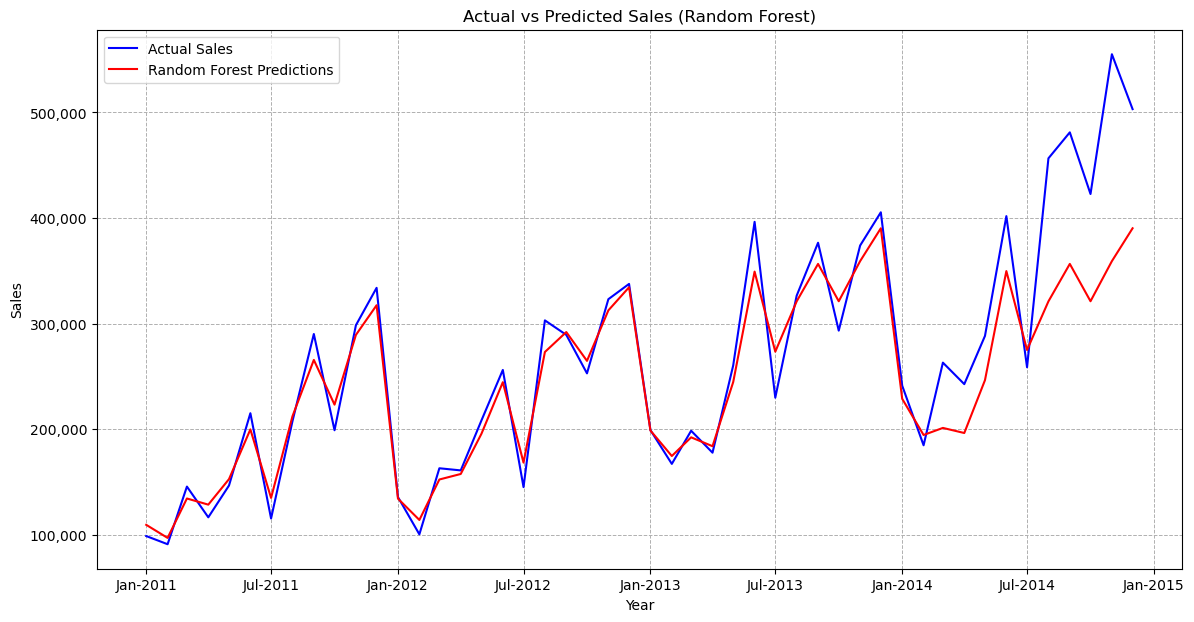

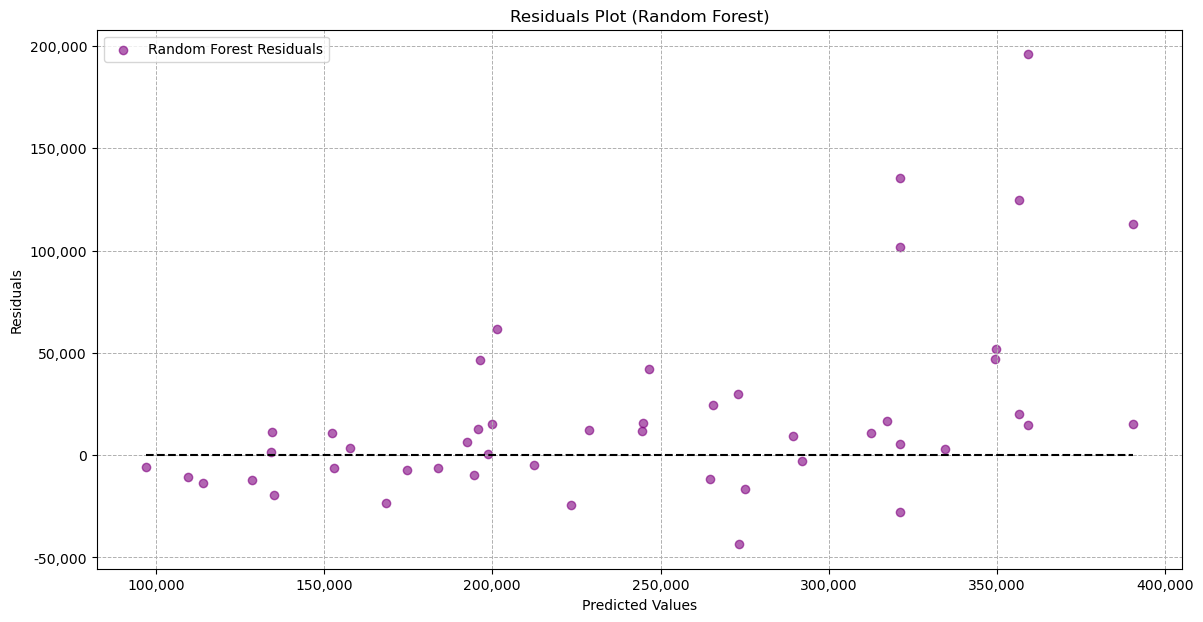

In [8]:
monthly_sales = df1.groupby(df1['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

# Feature Engineering
monthly_sales['month'] = monthly_sales['ds'].dt.month
monthly_sales['year'] = monthly_sales['ds'].dt.year

# Prepare data for Random Forest
X = monthly_sales[['month', 'year']]
y = monthly_sales['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# GridSearchCV for parameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_rf = best_rf_model.predict(X_test)

# Combine the training set and predictions for plotting
y_pred_rf_full = np.concatenate([best_rf_model.predict(X_train), y_pred_rf])

# Evaluate model
rmse_rf = np.sqrt(mean_squared_error(y, y_pred_rf_full))
mean_sales = np.mean(y)
normalized_rmse_rf = rmse_rf / mean_sales
r2_rf = r2_score(y, y_pred_rf_full)

print(f'Normalized RMSE of Random Forest: {normalized_rmse_rf:.4f}')
print(f'R² of Random Forest: {r2_rf}')

# Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['ds'], y, label='Actual Sales', color='blue')
plt.plot(monthly_sales['ds'], y_pred_rf_full, label='Random Forest Predictions', color='red')
plt.title('Actual vs Predicted Sales (Random Forest)')
plt.xlabel('Year')
plt.ylabel('Sales')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  # Show only Jan and Jul on the x-axis

plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.legend(loc='upper left')
plt.show()

# Calculate residuals
residuals_rf = y - y_pred_rf_full

# Residuals plot
plt.figure(figsize=(14, 7))
plt.scatter(y_pred_rf_full, residuals_rf, label='Random Forest Residuals', color='purple', alpha=0.6)
plt.hlines(y=0, xmin=min(y_pred_rf_full), xmax=max(y_pred_rf_full), colors='black', linestyles='--')
plt.title('Residuals Plot (Random Forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.legend()
plt.show()

In [9]:
# Exponential Smoothing forecast

Normalized RMSE of Exponential Smoothing: 0.0956
R² of Exponential Smoothing: 0.9500595530360999


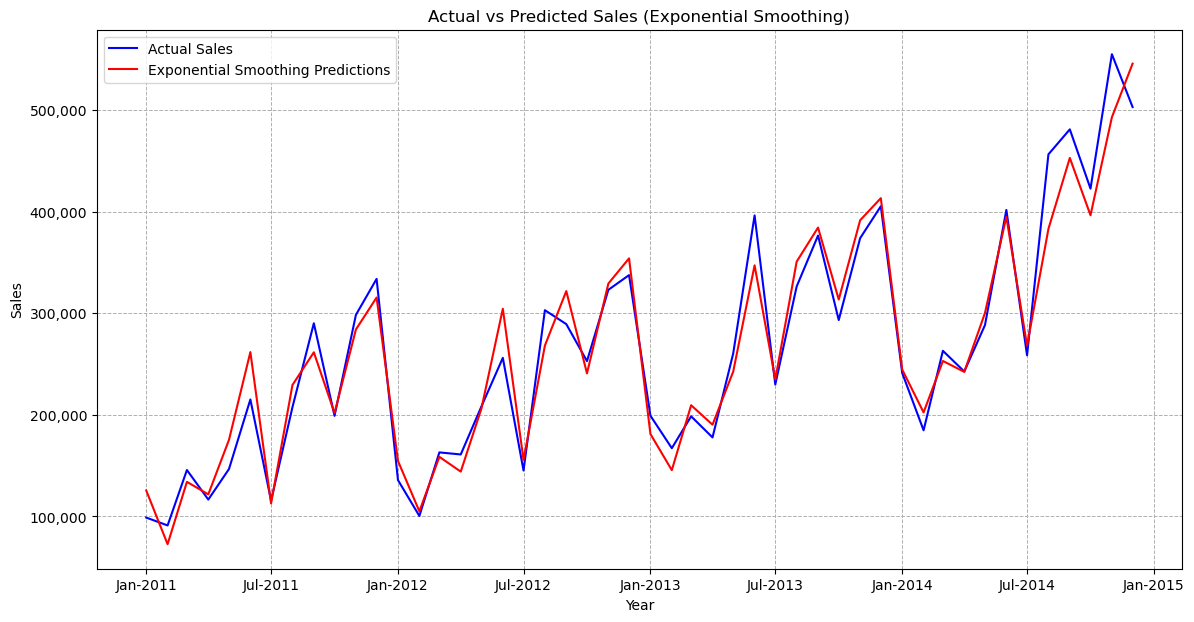

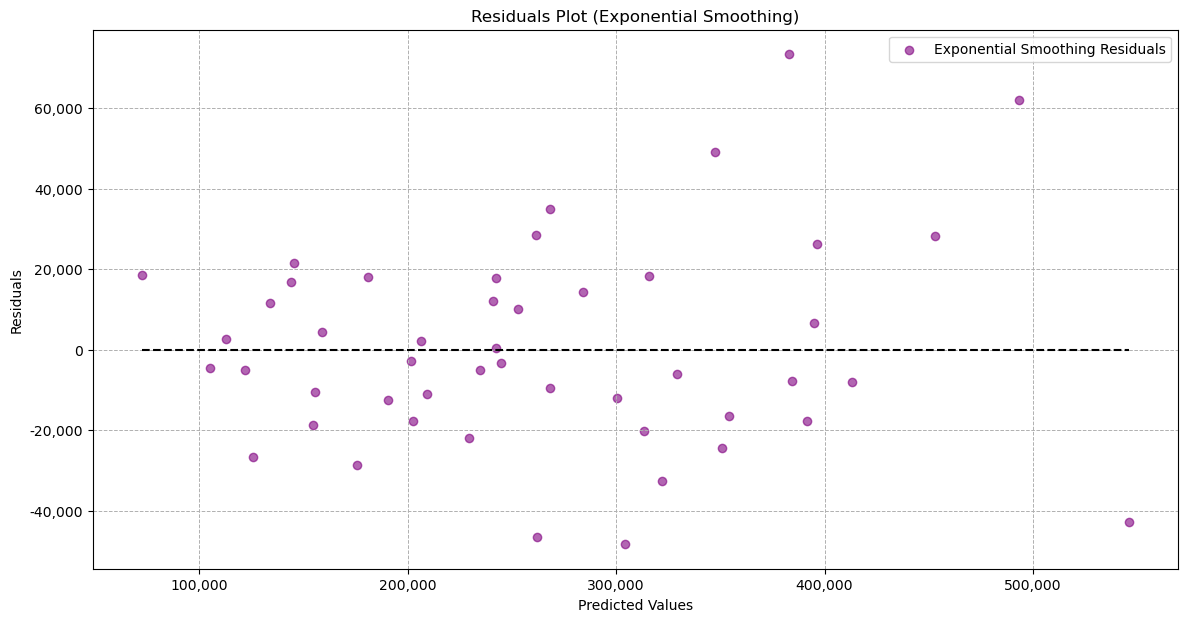

In [10]:
monthly_sales = df2.groupby(df2['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

# Grid search for parameter tuning
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [12],
}

all_params = list(itertools.product(*param_grid.values()))

results = []


for params in all_params:
    trend, seasonal, seasonal_periods = params
    
    
    if seasonal is None and trend is None:
        continue
    
    try:
        
        model = ExponentialSmoothing(monthly_sales['y'],
                                     trend=trend,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods)
        model_fit = model.fit(optimized=True)
        
        # Make predictions
        y_pred = model_fit.fittedvalues
        
        rmse = np.sqrt(mean_squared_error(monthly_sales['y'], y_pred))
        
        results.append((params, rmse, y_pred))
    
    except Exception as e:
        continue

# Find the best model
best_params, best_rmse, best_y_pred = sorted(results, key=lambda x: x[1])[0]

y_true = monthly_sales['y'].values  

# Evaluate model
mean_sales = np.mean(y_true)
normalized_rmse = best_rmse / mean_sales

r2_best = r2_score(y_true, best_y_pred)

print(f'Normalized RMSE of Exponential Smoothing: {normalized_rmse:.4f}')
print(f'R² of Exponential Smoothing: {r2_best}')

# Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['ds'], y_true, label='Actual Sales', color='blue')
plt.plot(monthly_sales['ds'], best_y_pred, label='Exponential Smoothing Predictions', color='red')
plt.title('Actual vs Predicted Sales (Exponential Smoothing)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  
plt.legend(loc='upper left')
plt.show()

# Calculate residuals
residuals_best = y_true - best_y_pred

# Residuals plot
plt.figure(figsize=(14, 7))
plt.scatter(best_y_pred, residuals_best, label='Exponential Smoothing Residuals', color='purple', alpha=0.6)
plt.hlines(y=0, xmin=min(best_y_pred), xmax=max(best_y_pred), colors='black', linestyles='--')
plt.title('Residuals Plot (Exponential Smoothing)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  
plt.legend()
plt.show()

In [11]:
# Prophet forecast

11:50:46 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:49 - cmdstanpy - INFO - Chain [1] done processing
11:50:49 - cmdstanpy - INFO - Chain [1] start processing
11:50:49 - cmdstanpy - INFO - Chain [1] done processing
11:50:49 - cmdstanpy - INFO - Chain [1] start processing
11:50:50 - cmdstanpy - INFO - Chain [1] done processing
11:50:50 - cmdstanpy - INFO - Chain [1] start processing
11:50:51 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Normalized RMSE of Prophet: 0.0568
R² of Prophet: 0.9823813883163476


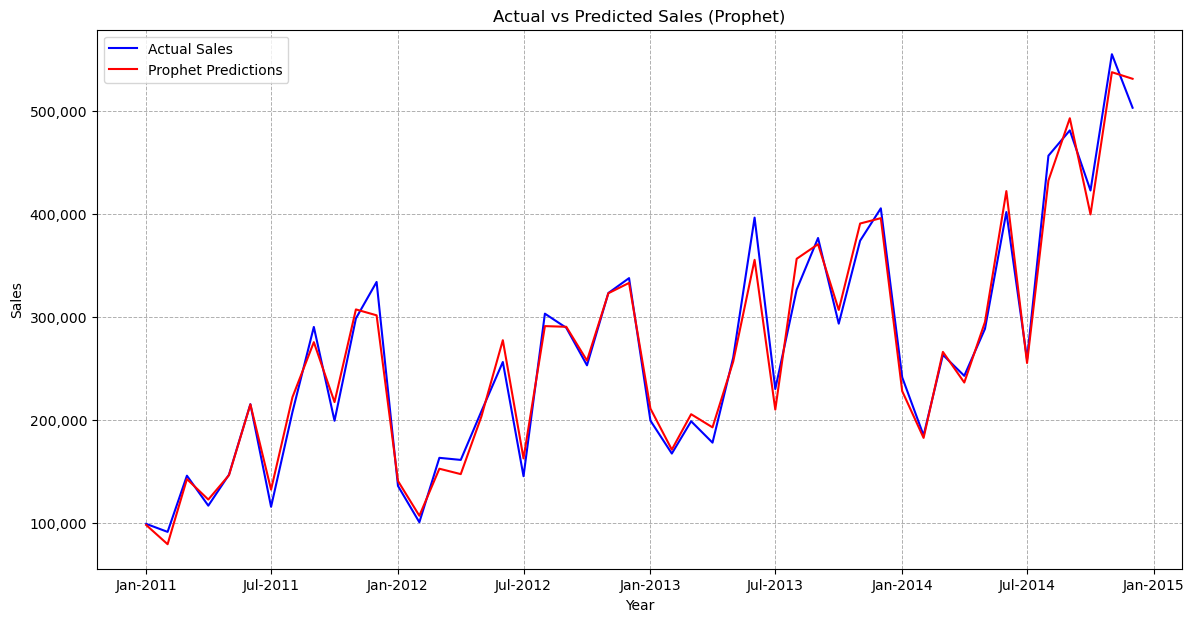

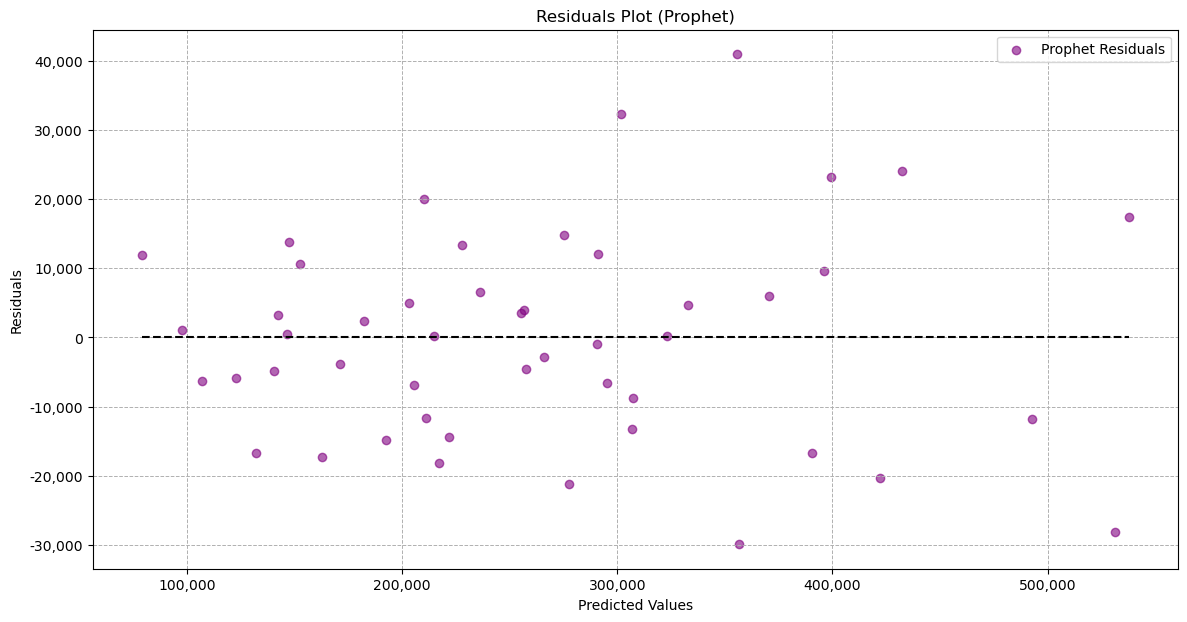

In [12]:
monthly_sales = df3.groupby(df3['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

# Grid search for parameter tuning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],  
    'seasonality_prior_scale': [1.0, 10.0, 20.0], 
    'seasonality_mode': ['additive', 'multiplicative']  
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []

for params in all_params:
   
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        yearly_seasonality=True,
        weekly_seasonality=False
    )
    
    model.fit(monthly_sales)
    
    # Make predictions using best model
    forecast = model.predict(monthly_sales[['ds']])
    
    y_pred = forecast['yhat'].values[:len(monthly_sales['y'])] 
    
    rmse = np.sqrt(mean_squared_error(monthly_sales['y'], y_pred))
    
    results.append((params, rmse, y_pred))
    

best_params, best_rmse, best_y_pred = sorted(results, key=lambda x: x[1])[0]

y_true = monthly_sales['y'].values  

# Evaluate model
mean_sales = np.mean(y_true)
normalized_rmse = best_rmse / mean_sales

r2_best = r2_score(y_true, best_y_pred)

print(f'Best Parameters: {best_params}')
print(f'Normalized RMSE of Prophet: {normalized_rmse:.4f}')
print(f'R² of Prophet: {r2_best}')

# Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['ds'], y_true, label='Actual Sales', color='blue')
plt.plot(monthly_sales['ds'], best_y_pred, label='Prophet Predictions', color='red')
plt.title('Actual vs Predicted Sales (Prophet)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  # Uniform grid lines
plt.show()

# Calculate residuals
residuals_best = y_true - best_y_pred

# Residuals plot
plt.figure(figsize=(14, 7))
plt.scatter(best_y_pred, residuals_best, label='Prophet Residuals', color='purple', alpha=0.6)
plt.hlines(y=0, xmin=min(best_y_pred), xmax=max(best_y_pred), colors='black', linestyles='--')
plt.title('Residuals Plot (Prophet)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  # Uniform grid lines
plt.show()

In [13]:
# ARIMA Forecast

Normalized RMSE of ARIMA: 0.2606
R² of ARIMA: 0.6290105709950393


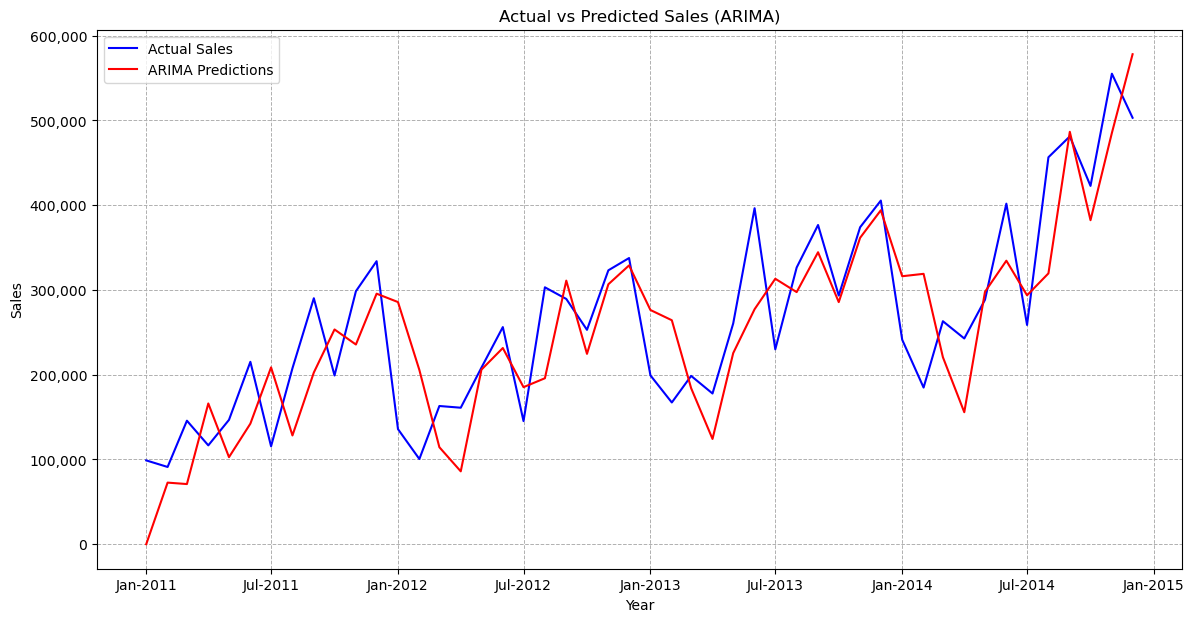

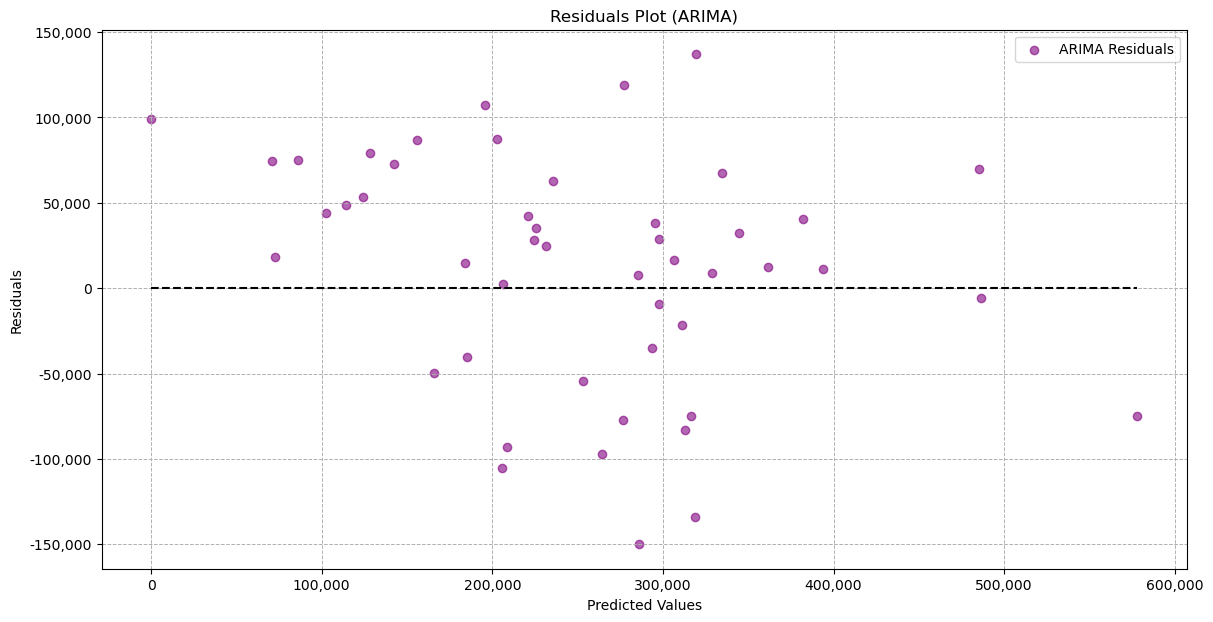

In [14]:
monthly_sales = df4.groupby(df4['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

monthly_sales.set_index('ds', inplace=True)

monthly_sales.index = monthly_sales.index.to_period('M').to_timestamp()

# Differencing to make the series stationary (if needed)
monthly_sales['y_diff'] = monthly_sales['y'].diff().dropna()

p = range(0, 4)
d = range(0, 2)  
q = range(0, 4)

pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

# Grid search for parameter tuning
for param in pdq:
    try:
        model = ARIMA(monthly_sales['y'], order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = param
            best_model = model_fit
    except:
        continue


# Make predictions using the best model
y_pred = best_model.predict(start=len(monthly_sales) - len(monthly_sales['y_diff']), end=len(monthly_sales) - 1, typ='levels')


y_true = monthly_sales['y'].iloc[-len(y_pred):]
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate model
mean_sales = np.mean(y_true)
normalized_rmse = rmse_arima / mean_sales

r2_arima = r2_score(y_true, y_pred)

print(f'Normalized RMSE of ARIMA: {normalized_rmse:.4f}')
print(f'R² of ARIMA: {r2_arima}')

# Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['y'], label='Actual Sales', color='blue')
plt.plot(monthly_sales.index[-len(y_pred):], y_pred, label='ARIMA Predictions', color='red')
plt.title('Actual vs Predicted Sales (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  # Show only Jan and Jul on x-axis
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  # Uniform grid lines
plt.show()

# Calculate residuals
residuals = y_true - y_pred

# Residuals plot
plt.figure(figsize=(14, 7))
plt.scatter(y_pred, residuals, label='ARIMA Residuals', color='purple', alpha=0.6)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='black', linestyles='--')
plt.title('Residuals Plot (ARIMA)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True, which='both', linestyle='--', linewidth=0.7)  # Uniform grid lines
plt.legend()
plt.show()

In [15]:
# Monte Carlo Simulation of different economic scenarios

11:51:01 - cmdstanpy - INFO - Chain [1] start processing
11:51:01 - cmdstanpy - INFO - Chain [1] done processing


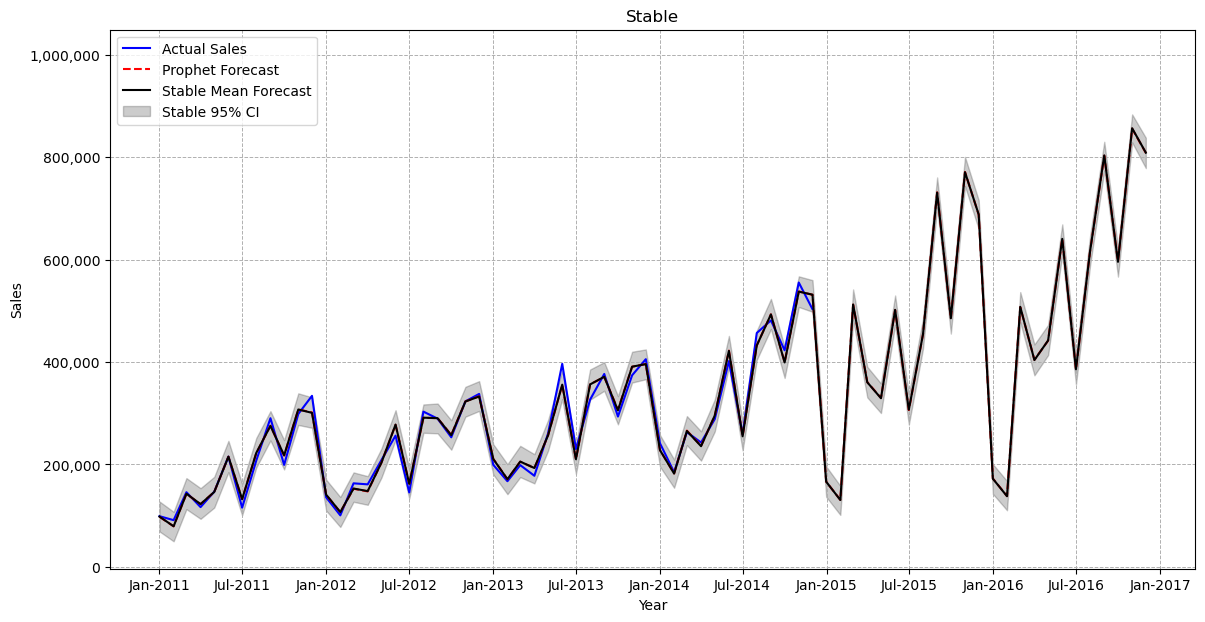

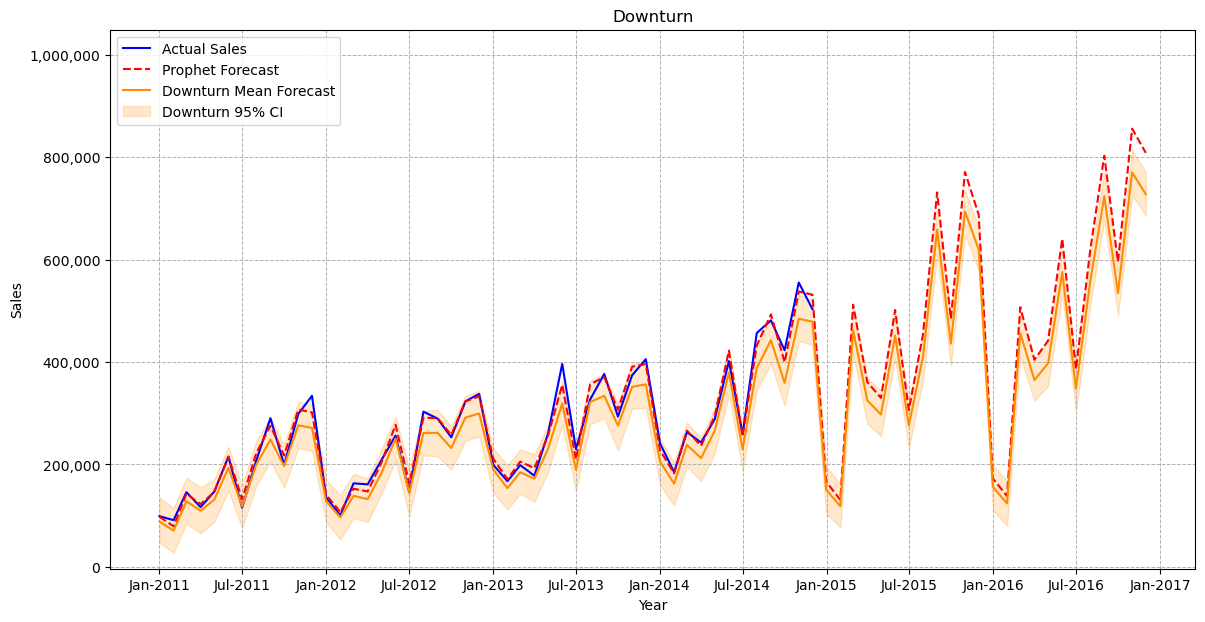

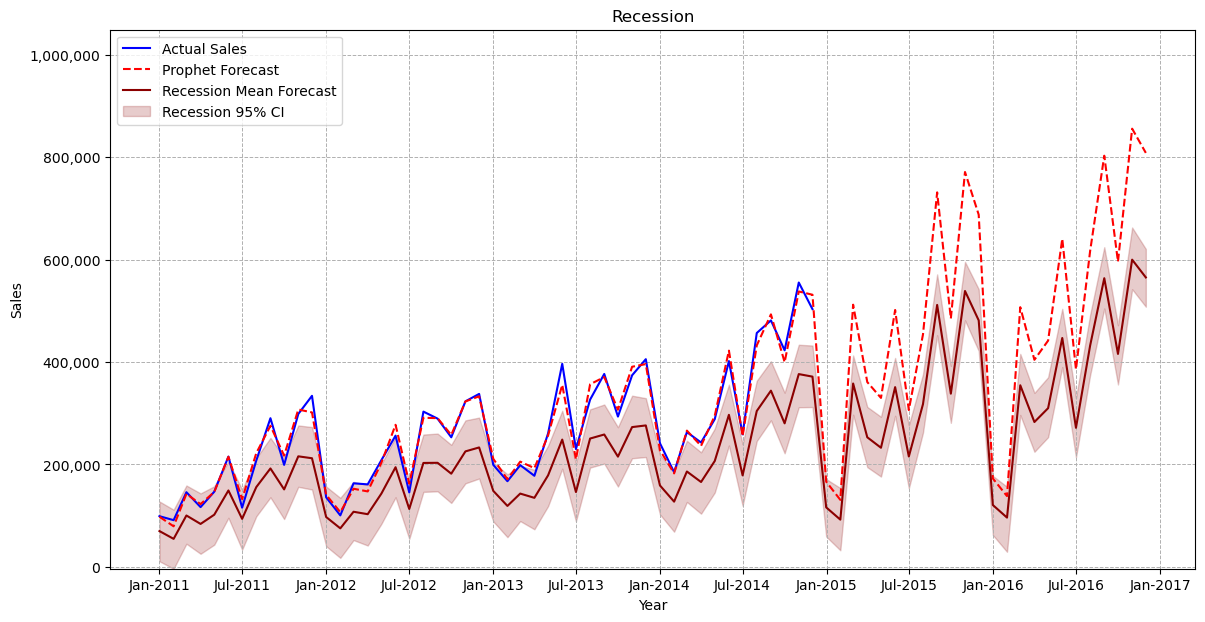

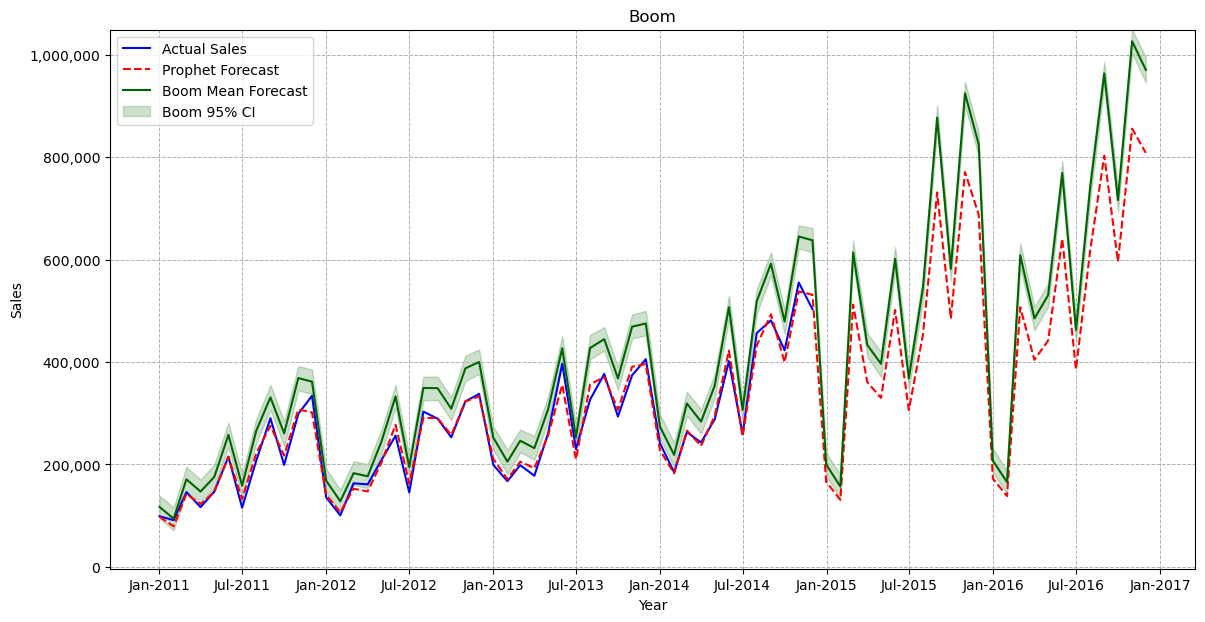

In [16]:
monthly_sales = df5.groupby(df5['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

# Use the best Prophet model
model = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=10.0,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False
)

model.fit(monthly_sales)

# Extend the forecast for two years
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

y_pred = forecast['yhat'].values[:len(monthly_sales['y'])]

# Estimate the standard deviation of the residuals to add noise
residuals = monthly_sales['y'].values - y_pred
error_std = np.std(residuals)

# Different economic scenarios
economic_scenarios = {
    'Stable': {'mean_shift': 0, 'std_multiplier': 1, 'color': 'black'},
    'Downturn': {'mean_shift': -0.1, 'std_multiplier': 1.5, 'color': 'darkorange'},
    'Recession': {'mean_shift': -0.3, 'std_multiplier': 2, 'color': 'darkred'},
    'Boom': {'mean_shift': 0.2, 'std_multiplier': 0.8, 'color': 'darkgreen'},
}

# Monte Carlo Simulation of economic scenarios
np.random.seed(42) 
n_simulations = 1000
simulated_scenarios = {}

y_min = np.inf
y_max = -np.inf

for scenario_name, params in economic_scenarios.items():
    mean_shift = params['mean_shift']
    std_multiplier = params['std_multiplier']
    
    # Run simulations
    simulated_sales = np.zeros((n_simulations, len(forecast)))
    for i in range(n_simulations):
        simulated_sales[i, :] = forecast['yhat'].values + mean_shift * forecast['yhat'].values + np.random.normal(0, error_std * std_multiplier, len(forecast))
    
    # Calculate mean forecast and confidence intervals
    mean_forecast = np.mean(simulated_sales, axis=0)
    lower_bound = np.percentile(simulated_sales, 2.5, axis=0)
    upper_bound = np.percentile(simulated_sales, 97.5, axis=0)
    
    y_min = min(y_min, lower_bound.min())
    y_max = max(y_max, upper_bound.max())
    
    simulated_scenarios[scenario_name] = {
        'mean_forecast': mean_forecast,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'color': params['color']
    }

# Plot scenarios
for scenario_name, results in simulated_scenarios.items():
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_sales['ds'], monthly_sales['y'], label='Actual Sales', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='red', linestyle='--')
    plt.plot(forecast['ds'], results['mean_forecast'], label=f'{scenario_name} Mean Forecast', color=results['color'])
    plt.fill_between(forecast['ds'], results['lower_bound'], results['upper_bound'], alpha=0.2, color=results['color'], label=f'{scenario_name} 95% CI')


    plt.ylim(y_min, y_max)  
    plt.title(f'{scenario_name}')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)  
    plt.legend(loc='upper left') 

    plt.show()

In [17]:
# Forecast scenarios for the next two years

11:51:03 - cmdstanpy - INFO - Chain [1] start processing
11:51:03 - cmdstanpy - INFO - Chain [1] done processing


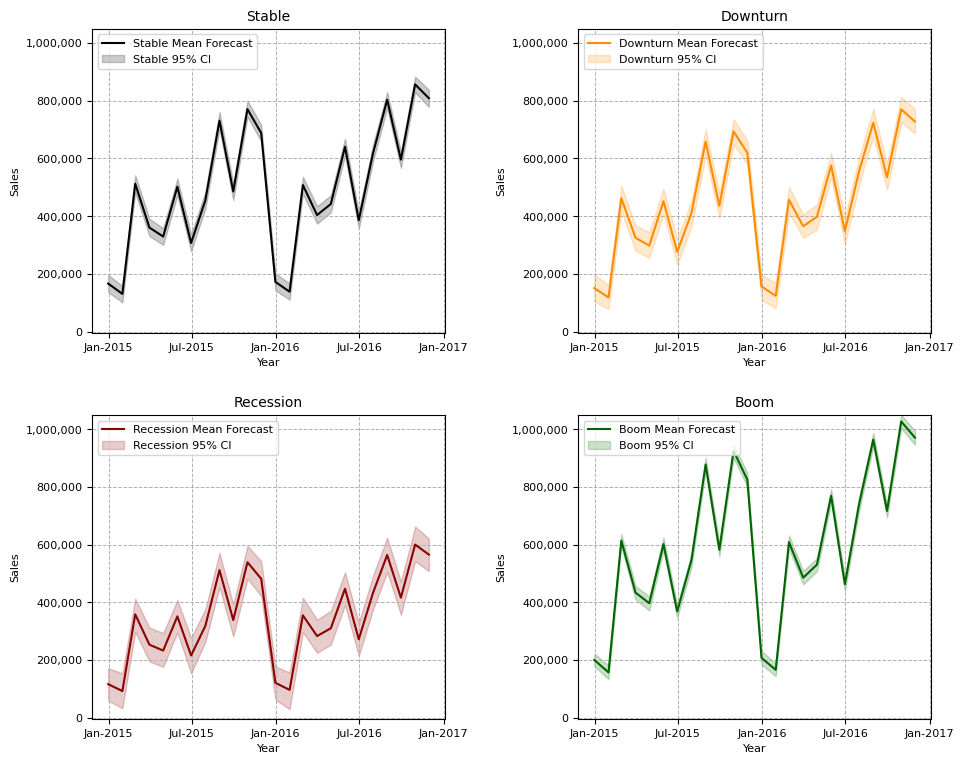

In [18]:
monthly_sales = df6.groupby(df6['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']
monthly_sales['ds'] = monthly_sales['ds'].dt.to_timestamp()

model = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=10.0,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False
)

model.fit(monthly_sales)

future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

y_pred = forecast['yhat'].values[:len(monthly_sales['y'])]

residuals = monthly_sales['y'].values - y_pred
error_std = np.std(residuals)

economic_scenarios = {
    'Stable': {'mean_shift': 0, 'std_multiplier': 1, 'color': 'black'},
    'Downturn': {'mean_shift': -0.1, 'std_multiplier': 1.5, 'color': 'darkorange'},
    'Recession': {'mean_shift': -0.3, 'std_multiplier': 2, 'color': 'darkred'},
    'Boom': {'mean_shift': 0.2, 'std_multiplier': 0.8, 'color': 'darkgreen'},
}

np.random.seed(42) 
n_simulations = 1000 
simulated_scenarios = {}

y_min = np.inf
y_max = -np.inf

for scenario_name, params in economic_scenarios.items():
    mean_shift = params['mean_shift']
    std_multiplier = params['std_multiplier']
    
    simulated_sales = np.zeros((n_simulations, len(forecast)))
    for i in range(n_simulations):
        simulated_sales[i, :] = forecast['yhat'].values + mean_shift * forecast['yhat'].values + np.random.normal(0, error_std * std_multiplier, len(forecast))
    
    mean_forecast = np.mean(simulated_sales, axis=0)
    lower_bound = np.percentile(simulated_sales, 2.5, axis=0)
    upper_bound = np.percentile(simulated_sales, 97.5, axis=0)
    
    y_min = min(y_min, lower_bound.min())
    y_max = max(y_max, upper_bound.max())
    
    simulated_scenarios[scenario_name] = {
        'mean_forecast': mean_forecast,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'color': params['color']
    }

fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 

scenario_names = list(simulated_scenarios.keys())
for i, ax in enumerate(axes.flatten()):
    scenario_name = scenario_names[i]
    results = simulated_scenarios[scenario_name]
    
    ax.plot(forecast['ds'][-24:], results['mean_forecast'][-24:], label=f'{scenario_name} Mean Forecast', color=results['color'])
    ax.fill_between(forecast['ds'][-24:], results['lower_bound'][-24:], results['upper_bound'][-24:], alpha=0.2, color=results['color'], label=f'{scenario_name} 95% CI')

    ax.set_ylim(y_min, y_max)  
    ax.set_title(f'{scenario_name}', fontsize=10)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Sales', fontsize=8)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=8, loc='upper left')  
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)  

plt.tight_layout(pad=2.0)
plt.show()